In [1]:
%matplotlib inline

In [2]:
from scipy import signal

In [3]:
from kid_readout.measurement.io import npy
from kid_readout.measurement import plot_basic
from kid_readout.analysis import detect_peaks
from kid_readout.analysis.resonator import find_resonators, lmfit_resonator

In [4]:
f_center = 1e6 * np.array([1991.8,  # no man's land; probably not an MKID
                           2584.1,  # Band 0, lower edge
                           2694.9,  # Band 1,
                           2798.2,  # no-man's land
                           2916.1,  # Band 2
                           2988.1,  # Band 3
                           3864.3,  # no man's land
                          ])

In [5]:
npd = npy.NumpyDirectory('/data/detectors/2017-02-28_163517_temperature_scan_paired.npd/')

In [6]:
sweeps = [npd.read(name) for name in npd.node_names() if name.startswith('SweepArray')]

# Raw data

In [8]:
background = np.load('background_0.9_K.npz')

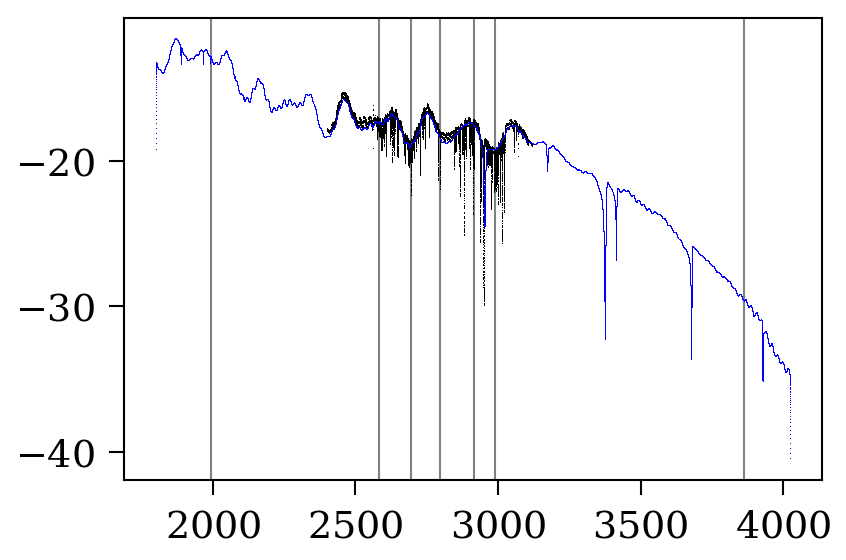

In [9]:
fig, ax = plt.subplots()
for f in f_center:
    ax.axvline(1e-6 * f, color='gray')
for sa in sweeps:
    ax.plot(sa.frequency_MHz, 20 * np.log10(np.abs(sa.s21_point)), ',k')
ax.plot(1e-6 * background['frequency'], 20 * np.log10(background['smoothed']), ',b')

# SweepArray

In [10]:
Q = 30000

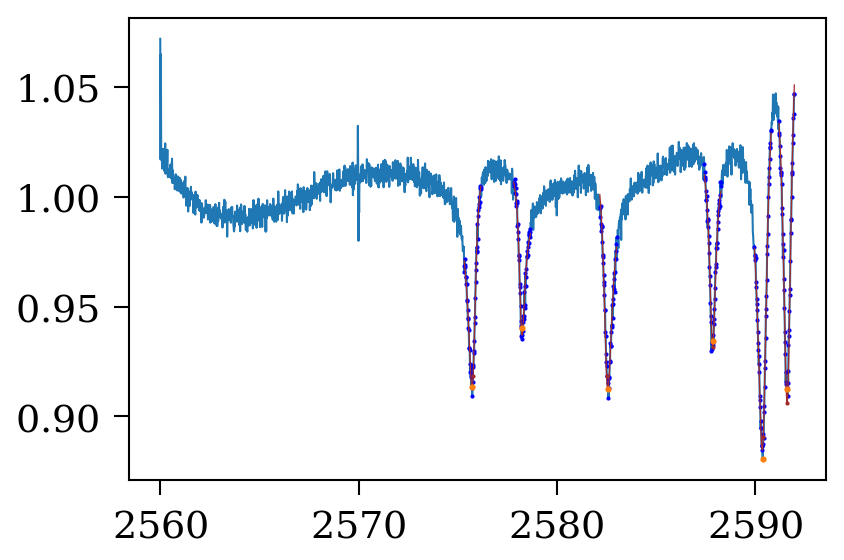

In [11]:
sa = sweeps[10]
peaks = sa.find_resonances(min_snr=0.1)
rs = [sa.resonator(frequency=sa.frequency[peak], width=10 * sa.frequency.mean() / Q,
                   model=lmfit_resonator.LinearLossResonatorWithCable)
      for peak in peaks]
fig, ax = plt.subplots()
ax.plot(sa.frequency_MHz, np.abs(sa.s21_point_foreground))
for r in rs:
    plot_basic.resonator_amplitude(r, ax, normalize=False, decibels=False, three_ticks=False)
ax.plot(sa.frequency_MHz[peaks], np.abs(sa.s21_point_foreground[peaks]), '.')


In [12]:
def fit_and_plot(sa, ax, min_snr=0.5, Q=30000, num_linewidths=10, threshold=1):
    peaks = sa.find_resonances(min_snr=min_snr, threshold=threshold)
    rs = [sa.resonator(frequency=sa.frequency[peak], width=num_linewidths * sa.frequency.mean() / Q,
                       model=lmfit_resonator.LinearLossResonatorWithCable)
          for peak in peaks]
    ax.plot(sa.frequency_MHz, np.abs(sa.s21_point_foreground), color='gray')
    ax.plot(sa.frequency_MHz[peaks], np.abs(sa.s21_point_foreground[peaks]), '.', color='black')
    for r in rs:
        plot_basic.resonator_amplitude(r, ax, normalize=False, decibels=False, three_ticks=False)

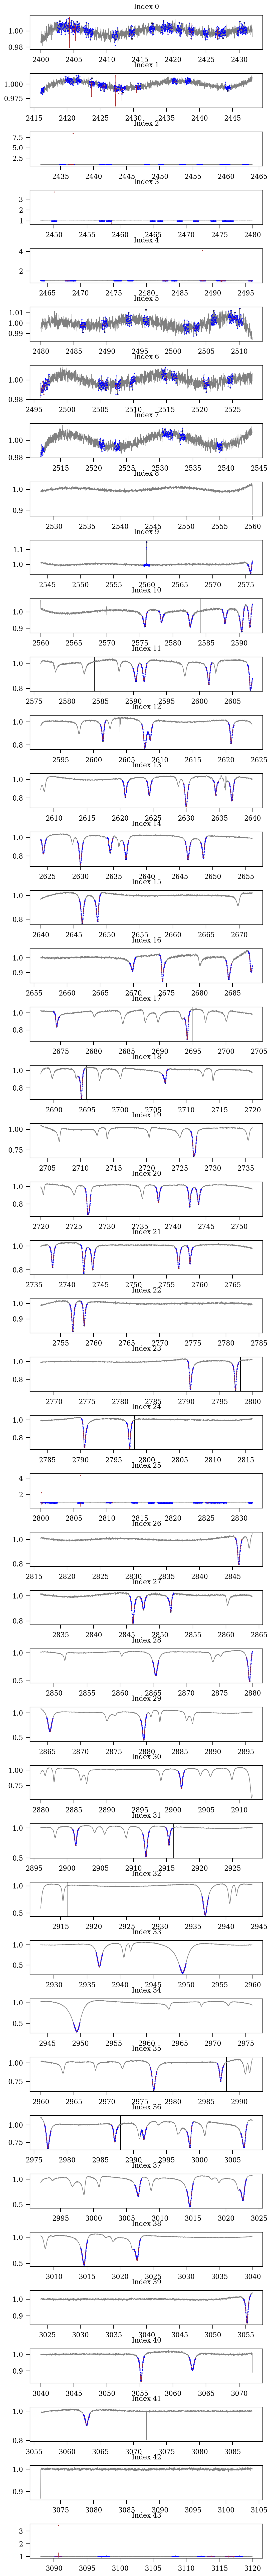

In [14]:
num_subplots = len(sweeps)
fig, axes = plt.subplots(num_subplots, 1, figsize=(4, num_subplots), gridspec_kw={'hspace': 0.8})
for index, (sa, ax) in enumerate(zip(sweeps, np.atleast_1d(axes).flatten())):
    ax.tick_params(labelsize='xx-small')
    ax.set_title("Index {}".format(index), fontsize='xx-small')
    for f in f_center[(sa.frequency.min() < f_center) & (f_center < sa.frequency.max())]:
        ax.axvline(1e-6 * f, color='black')
    fit_and_plot(sa, ax, min_snr=0.1, threshold=2)